# Topic Modeling (LDA) for lyrics - Detailed Coherence

## 0. Setup

In [92]:
#import libraries 

import re
import operator
import string
import random
random.seed(1)
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#nltk imports
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

#gensim imports
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

#lda-vis
import pyLDAvis.gensim_models

#spacy
import spacy
nlp = spacy.load('en_core_web_sm')

## 1. Loading Data

In [2]:
#create a df from csv
filename = "data/full_df.csv"
lyrics_df= pd.read_csv(filename)
lyrics_df.rename(columns={ 'Unnamed: 0': 'track_name'}, inplace=True)
lyrics_df.drop('Unnamed: 0.1', inplace=True, axis=1)
lyrics_df.head()

,track_name,playlist_name,playlist_id,playlist_genre,track_id,track_artist_name,track_artist_id,danceability,energy,key,loudness,mode,acousticness,valence,tempo,tabs,dirty_lyrics
0,Back In Black,Rock Classics,37i9dQZF1DWXRqgorJj26U,Rock,08mG3Y1vljYA6bvDt4Wqkj,AC/DC,711MCceyCBcFnzjGY4Q7Un,0.310,0.700,9,-5.678,1,0.0110,0.763,188.386,"E,D,A/C#,E,D,A/C#,E,D,A/C#,E,D,A/C#,E,D,A/C#,A...","[Verse 1]\nBack in black, I hit the sack\nI've..."
1,Paradise City,Rock Classics,37i9dQZF1DWXRqgorJj26U,Rock,3YBZIN3rekqsKxbJc9FZko,Guns N' Roses,3qm84nBOXUEQ2vnTfUTTFC,0.273,0.952,11,-8.762,1,0.0169,0.472,100.271,"G,C,F,C,G,G5,F5,C5,Bb5,C5,C5,Bb5,G,F,G,G,G,C,C...",[Chorus]\nTake me down to the Paradise City\nW...
2,Dream On,Rock Classics,37i9dQZF1DWXRqgorJj26U,Rock,5MxNLUsfh7uzROypsoO5qe,Aerosmith,7Ey4PD4MYsKc5I2dolUwbH,0.307,0.433,1,-10.057,1,0.3880,0.224,160.900,"Fm,Fm6,Bbm6,Fm,C7sus,Fm,Fm,Fm7,Fm6,Bbm6,Fm,Fm7...",[Verse 1]\nEvery time​ that I look in the mirr...
3,Creep,Rock Classics,37i9dQZF1DWXRqgorJj26U,Rock,70LcF31zb1H0PyJoS1Sx1r,Radiohead,4Z8W4fKeB5YxbusRsdQVPb,0.515,0.430,7,-9.935,1,0.0097,0.104,91.844,"G,B,C,Cm,G,B,C,Cm,G,B,C,Cm,G,B,C,Cm,G,B,C,Cm,G...",[Verse 1]\nWhen you were here before\nCouldn't...
4,Don't Stop Believin',Rock Classics,37i9dQZF1DWXRqgorJj26U,Rock,4bHsxqR3GMrXTxEPLuK5ue,Journey,0rvjqX7ttXeg3mTy8Xscbt,0.500,0.748,4,-9.072,1,0.1270,0.514,118.852,"E,B,C#m,A,E,B,G#m,A,E,B,C#m,A,E,B,G#m,A,E,B,C#...",[Verse 1]\nJust a small-town girl\nLivin' in a...


In [3]:
lyrics_df.shape

(1701, 17)

In [4]:
lyrics_df.columns

Index(['track_name', 'playlist_name', 'playlist_id', 'playlist_genre',
       'track_id', 'track_artist_name', 'track_artist_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'acousticness', 'valence', 'tempo',
       'tabs', 'dirty_lyrics'],
      dtype='object')

## 1. Data Cleaning

In [5]:
#use length to filter out non-lyrics
lyrics_df['len'] = None
lyrics_df['len'] = lyrics_df['dirty_lyrics'].apply(lambda x: len(str(x)))
lengths = list(lyrics_df['len'])
percentiles = [90, 91, 92, 93, 94, 95, 99]
for p in percentiles:
    print(np.percentile(lengths, p))

3092.0
3246.0
3580.0
3853.0
4322.0
5001.0
89514.0


1564
1701


(array([ 68.,  44., 188., 391., 388., 248., 121.,  56.,  36.,  24.]),
 array([3.0000e+00, 3.5780e+02, 7.1260e+02, 1.0674e+03, 1.4222e+03,
        1.7770e+03, 2.1318e+03, 2.4866e+03, 2.8414e+03, 3.1962e+03,
        3.5510e+03]),
 <BarContainer object of 10 artists>)

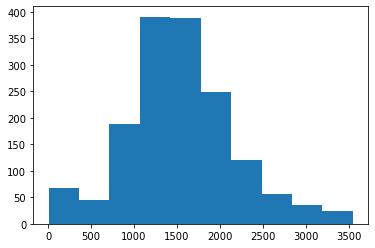

In [6]:
ldf = lyrics_df.loc[lyrics_df.len < np.percentile(lengths, 92)]
print(len(ldf))
print(len(lyrics_df))
plt.hist(ldf.len, bins=10)

In [7]:
#drop NAs from lyrics col
print(ldf.shape)
ldf = ldf[ldf['dirty_lyrics'].notna()]
ldf.reset_index(drop=True, inplace=True)
print(ldf.shape)

(1564, 18)
(1496, 18)


In [8]:
#french lyrics crept in from somewhere, drop it
#found this index heuristically, need to check for other bad data
ldf.iloc[776,-2]

'[Paroles de "RATPI WORLD"]\n\n[Intro]\nArmes automatiques, c\'est fantastique\nC\'est quoi les bails, ma gueule ?\nJ\'suis dans mon Ratpi World, eh\n\n[Couplet 1]\nIls sont v\'nus à six du mat\', rangers, pas de bas résille\nIls veulent nous faire comme rats des villes, encerclés comme en Palestine\nLe pare-chocs embrasse la vitrine, D.U.C : pas d\'la Cristalline\nWallaye, j\'suis sur toi comme un Djinn, c\'est plus grave que tu l\'imagines\nGargouilles sur un toit béni, rate-pi patrouille jour et nuit\nSi tu sais pas qui j\'suis, ton écran plat vient d\'chez Momo Henni\nTout est écrit mais j\'aime pas lire, t\'es faux, ta peau c\'est pas du cuir\nPlein d\'gens que j\'aime mais j\'aime pas l\'dire, plein d\'gens qu\'je gêne veulent me détruire\nQu\'il en soit ainsi, j\'ai toujours laissé le Diable me séduire\nDans l\'bureau à Tony, lance-grenades chargé, grosse cérémonie\nC\'est dur, frérot, la pandémie, avance-moi un kil\' et d\'mi\n9-2, Porte de Châtillon, Lamborghini, portes papill

In [9]:
ldf = ldf.drop(ldf.index[776])

In [10]:
print(ldf.shape)

(1495, 18)


### Helper Functions

In [11]:
def clean_lyrics(lyrics):

    #remove verse/chorus/bridge etc. inside []
    cleaned_lyrics = re.sub(r'\[(.*?)\]','', lyrics)
    #remove genius *embed* words
    cleaned_lyrics = re.sub(r"\S*Embed\S*",'', cleaned_lyrics)
    
    #The below code may be required for some other parts of pipeline
    #For LDA, it is baked into lyrics_to_words
    
    #lowercase and strip
    #cleaned_lyrics = cleaned_lyrics.lower().strip()
    #remove punctuations
    #cleaned_lyrics = re.sub(r"[^\w\d'\s]+",'', cleaned_lyrics)
    
    return cleaned_lyrics 

In [12]:
def read_stopwords(filename):
    stopwords={}
    with open(filename) as file:
        for line in file:
            stopwords[line.rstrip()]=1
    return stopwords

In [50]:
def lyrics_to_words(lyrics):
    
    #for lemmatization
    #lemma = WordNetLemmatizer()
    
    #lowercase and strip
    tokens = nltk.wordpunct_tokenize(lyrics.lower())
    #tokens = lyrics.lower().split()
        
    stop_words = {k:1 for k in stopwords.words('english')}
    stop_words.update(read_stopwords("data/jockers.stopwords"))
    stop_words["'s"]=1
    stop_words=list(stop_words.keys())
    
    s1 = set(string.punctuation)
    my_punct = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.',
           '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 
           '`', '{', '|', '}', '~', '»', '«', '“', '”']
    s2 = set(my_punct)
    exclude = set.union(s1,s2)
    
    stopword_removal = [token for token in tokens if token not in stop_words]
    punct_removal = [token for token in stopword_removal if token not in exclude]
    alnum = [token for token in punct_removal if token.isalnum()]
    #normalized = [lemma.lemmatize(word) for word in alnum]
    
    return alnum

In [21]:
#test helper funcs
print(lyrics_to_words(clean_lyrics(str(ldf.dirty_lyrics[0]))))

['black', 'hit', 'sack', 'glad', 'loose', 'noose', 'kept', 'hanging', 'looking', 'sky', 'cause', 'getting', 'high', 'forget', 'hearse', 'cause', 'die', 'lives', 'cat', 'eyes', 'abusing', 'running', 'wild', 'cause', 'black', 'black', 'cadillac', 'number', 'bullet', 'power', 'pack', 'bang', 'gang', 'catch', 'want', 'cause', 'track', 'beatin', 'flack', 'gonna', 'rap', 'look', 'making', 'play', 'push', 'luck', 'cause', 'black', 'black', 'black', 'black', 'yow', 'ah', 'yeah', 'yeah', 'take', 'yeah', 'yeah', 'yeah', 'ah', 'hey', 'yeah', 'ooh', 'yeah', 'black', 'black', 'hit', 'sack']


#### [Phrase Modeling](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

Used code from this article to implement gensim's phrase modeling

In [40]:
lyrics = ldf.dirty_lyrics.to_list()
lyrics_words = [lyrics_to_words(clean_lyrics(str(l))) for l in lyrics]

In [32]:
lyrics = ldf.dirty_lyrics.to_list()
lyrics_words = [clean_lyrics(str(l)).split() for l in lyrics]

In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lyrics_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[lyrics_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [37]:
for idx, row in ldf.iterrows():
    if "agua" in row['dirty_lyrics']:
        print(idx)
        print(row['dirty_lyrics'])

281
[Verse 1]
She'll only come out at night
The lean and hungry type
Nothing is new
I've seen her here before
Watching and waiting
Ooh, she's sitting with you, but her eyes are on the door
So many have paid to see what you think you're getting for free
The woman is wild, a she-cat tamed by the purr of a Jaguar
Money's the matter
If you're in it for love, you ain't gonna get too far

[Chorus]
(Oh-oh, here she comes)
Watch out, boy, she'll chew you up
(Oh-oh, here she comes)
She's a maneater
(Oh-oh, here she comes)
Watch out, boy, she'll chew you up
(Oh-oh, here she comes)
She's a maneater

[Verse 2]
I wouldn't if I were you
I know what she can do
She's deadly, man
She could really rip your world apart
Mind over matter
Ooh, the beauty is there but a beast is in the heart
[Chorus]
(Oh-oh, here she comes)
Watch out, boy, she'll chew you up
(Oh-oh, here she comes)
She's a maneater
(Oh-oh, here she comes)
Watch out, boy, she'll chew you up
(Oh-oh, here she comes)
She's a maneater
[Instrument

In [42]:
bigram_mod.phrasegrams

{'grass_green': 160.03764320785598,
 'small_town': 184.90667408231369,
 'born_raised': 113.96620046620046,
 'wait_complaint': 204.9958071278826,
 'complaint_forever': 181.07962962962964,
 'forever_debt': 181.07962962962964,
 'debt_priceless': 3621.5925925925926,
 'priceless_advice': 2037.1458333333333,
 'rock_roll': 102.62104202052005,
 'dime_jukebox': 189.50193798449612,
 'honky_tonk': 3716.897660818713,
 'zombie_zombie': 2037.1458333333333,
 'du_du': 236.1622992392223,
 'eh_eh': 442.5667431334863,
 'outer_space': 377.5405405405406,
 'needed_needed': 198.62171875,
 'memoria_memoria': 2314.390532544379,
 'joker_thief': 543.2388888888889,
 'change_mould': 115.994068801898,
 'violence_silence': 260.06117021276594,
 'da_da': 110.6566362218757,
 'lo_lo': 462.1124763705104,
 'ay_ay': 1004.8009734991887,
 'heh_heh': 2166.936288088643,
 'shake_shake': 137.22095626315613,
 'dirty_deeds': 695.6107723577236,
 'deeds_done': 171.05804707379136,
 'dirt_cheap': 308.0220504009164,
 'cheap_dirty': 165

In [43]:
trigram_mod.phrasegrams

{'paradise_city': 122.21751724137931,
 'grass_green': 284.44348140122787,
 'grass_green_girls': 133.74494820852436,
 'small_town': 637.6813563627127,
 'born_raised': 174.35596221959858,
 'priceless_advice': 18752.95238095238,
 'forever_debt_priceless_advice': 252.28187059577192,
 'rock_roll': 220.29170346817403,
 'dime_jukebox': 321.74183006535947,
 'du_du': 1632.5114795918369,
 'du_du_du_du': 251.15561224489795,
 'eh_eh': 3295.161632653061,
 'needed_needed': 175.5998810939358,
 'memoria_memoria': 98453.0,
 'joker_thief': 1823.2037037037037,
 'change_mould': 482.6127450980392,
 'violence_silence': 546.9611111111111,
 'da_da': 421.36263374485594,
 'lo_lo': 818.1689750692522,
 'ay_ay': 3938.12,
 'heh_heh': 32817.666666666664,
 'shake_shake': 457.32268834373633,
 'dirty_deeds': 7068.420512820512,
 'dirty_deeds_done': 108.89723479135243,
 'dirt_cheap': 762.6640845070423,
 'done_dirt_cheap': 212.34960784313725,
 'dirt_cheap_dirty_deeds': 1386.661971830986,
 'lasts_forever': 662.239910313901

In [44]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
# Form Bigrams
lyrics_words_bigrams = make_bigrams(lyrics_words)

# Do lemmatization keeping only noun, adj, vb, adv
lyrics_words_lemmatized = lemmatization(lyrics_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

['live', 'easy', 'lovin', 'free', 'ticket', 'ride', 'ask', 'leave', 'everythin', 'stride', 'need', 'reason', 'need', 'rhyme', 'goin', 'party', 'time', 'friend', 'gon', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'sign', 'speed', 'limit', 'gon', 'slow', 'wheel', 'gon', 'spin', 'gon', 'mess', 'satan', 'payin', 'due', 'play', 'rock', 'band', 'mama', 'promise', 'land', 'woo', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'heh_heh', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'highway', 'hell', 'go', 'highway']


In [47]:
print(lyrics_words_lemmatized[0])

['black', 'hit', 'sack', 'glad', 'loose', 'noose', 'keep', 'hang', 'look', 'sky', 'cause', 'get', 'high', 'forget', 'hearse', 'cause', 'die', 'live', 'cat', 'eye', 'abuse', 'run', 'wild', 'cause', 'black', 'black', 'cadillac', 'number', 'bullet', 'power', 'pack', 'bang', 'gang', 'catch', 'want', 'cause', 'track', 'beatin', 'flack', 'gon', 'rap', 'look', 'make', 'play', 'push', 'luck', 'cause', 'black', 'black', 'black', 'black', 'yow', 'take', 'black', 'black', 'hit', 'sack']


### No Phrase Modeling

In [53]:
ldf['cleaned_lyrics'] = None
ldf['cleaned_lyrics'] = ldf['dirty_lyrics'].apply(lambda x: clean_lyrics(str(x)))
ldf['words_for_LDA'] = None
ldf['words_for_LDA'] = ldf['cleaned_lyrics'].apply(lambda x: lyrics_to_words(str(x)))

In [56]:
words = ldf['words_for_LDA'].tolist()
track_id = ldf['track_id'].tolist()

In [79]:
#note issue with using this in model
lem_words = lemmatization(words)

In [78]:
lem_words[1011]

['strange',
 'bed',
 'pound',
 'head',
 'glitter',
 'room',
 'pink',
 'flamingos',
 'pool',
 'smell',
 'minibar',
 'pass',
 'yard',
 'barbie',
 'barbeque',
 'hickey',
 'bruise',
 'picture',
 'night',
 'end',
 'online',
 'screw',
 'black',
 'blur',
 'pretty',
 'sure',
 'rule',
 'damn',
 'friday',
 'night',
 'dance',
 'tabletop',
 'take',
 'shot',
 'kiss',
 'forgot',
 'friday',
 'night',
 'maxe',
 'credit',
 'card',
 'kick',
 'bar',
 'hit',
 'boulevard',
 'friday',
 'night',
 'streaking',
 'park',
 'skinny',
 'dip',
 'dark',
 'ménage',
 'trois',
 'friday',
 'night',
 'break',
 'law',
 'gon',
 'op',
 'whoa',
 'friday',
 'night',
 'friday',
 'night',
 'try',
 'connect',
 'dot',
 'boss',
 'city',
 'tow',
 'car',
 'chandelier',
 'floor',
 'rip',
 'favorite',
 'party',
 'dress',
 'warrant',
 'arrest',
 'need',
 'ale',
 'epic',
 'fail',
 'picture',
 'night',
 'end',
 'online',
 'screw',
 'black',
 'blur',
 'pretty',
 'sure',
 'rule',
 'damn',
 'friday',
 'night',
 'dance',
 'tabletop',
 'take'

## 2. Topic Modeling

### With Phrase Modeling

In [65]:
pm_dictionary = corpora.Dictionary(lyrics_words_lemmatized)
pm_corpus = [dictionary.doc2bow(text) for text in lyrics_words_lemmatized]

In [68]:
pm_lda_model = gensim.models.ldamodel.LdaModel(corpus=pm_corpus,
                                           id2word=pm_dictionary,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [80]:
num_topics = 50
pm_topics = {}
for i in range(num_topics):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in pm_lda_model.show_topic(i, topn=20)])))
    pm_topics[i] = ' '.join([term for term, freq in pm_lda_model.show_topic(i, topn=20)])

topic 0:	heart start light roll beat ready stick answer ass sign self build funny end whoa strike space stop let stranger
topic 1:	wish beautiful look care happy perfect float notice weirdo eye world battin fret missus roar testify pepsi weatherman tupelo boxin
topic 2:	hear bad say damn ruin crack runnin chain quit nasty life play late want prob ammunition barb factory pissed graceland
topic 3:	old friend lot memory rest reach raise american peace mad thinkin surely late enemy long car higher claim soak hurry
topic 4:	life world fight die burn cry rise pull smoke blood drown father poor drunk steal breathe somethin cold future crash
topic 5:	feel call real forever ring wonder harm belong turn nice sell rolling dime yesterday fake carry pretend deal circle drinkin
topic 6:	red foot stone ground water hair gun promise green empty make earth force truck stupid fat race attack record grey
topic 7:	name rock sound sky sea fly scream river air sand dig ocean skin flow darling cloud human be

In [89]:
#coherence

# Compute Coherence Score
pm_coherence_model_lda = CoherenceModel(model=pm_lda_model, texts=lyrics_words_lemmatized, dictionary=pm_dictionary, coherence='c_v')
pm_coherence_lda = pm_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', pm_coherence_lda)


Coherence Score:  0.35536824026240743


### Without Phrase Modeling

In [83]:
npm_dictionary = corpora.Dictionary(words)
npm_corpus = [dictionary.doc2bow(text) for text in words]

In [84]:
npm_lda_model = gensim.models.ldamodel.LdaModel(corpus=npm_corpus,
                                           id2word=npm_dictionary,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [85]:
num_topics = 50
npm_topics = {}
for i in range(num_topics):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in npm_lda_model.show_topic(i, topn=20)])))
    npm_topics[i] = ' '.join([term for term, freq in npm_lda_model.show_topic(i, topn=20)])

topic 0:	gets worry thinkin fighting cryin fightin hey candles strapped promises snakes picture thinking refinery swing hand foreign indecision little crept
topic 1:	rags favorite gamble cigarette wildcat everythin boys singing symphony action alive ad tender kept nearly pull defenses turned works drugstore
topic 2:	child lived straw wrapped kisses greed revolution attack transmissions aww plants fleas social seed ocean met interchanging ticket beaches artist
topic 3:	special 1916 live ascend gave lose growl stuttering ball ready afraid pass violence enraged money showed funny night redefine climb
topic 4:	blues single perfect woman blowin help midnight skin competition blowing detroit worse world creole alright band notice baggies payin brown
topic 5:	fame beatin wild noose girl fooling dig cat amen running crowd ah waiver jazz goodnight london dog cadillac luck making
topic 6:	wichita alabamy tonight face knows pick known alabama taste mutulu faked governor headlines chrome tuck airp

In [90]:
#coherence

# Compute Coherence Score
npm_coherence_model_lda = CoherenceModel(model=npm_lda_model, texts=words, dictionary=npm_dictionary, coherence='c_v')
npm_coherence_lda = npm_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', npm_coherence_lda)


Coherence Score:  0.5565846713243761


## 3. Hyperparameter tuning for coherence

[Ref1](https://datascience.oneoffcoder.com/topic-modeling-gensim.html)

### phrase modeling

In [105]:
pm_results_um = []

for t in range(30, 101, 10):
    lda_model = gensim.models.LdaModel(pm_corpus, id2word=pm_dictionary, num_topics=t)
    corpus_lda = lda_model[pm_corpus]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    pm_results_um.append(tup)

pm_results_um = pd.DataFrame(pm_results_um, columns=['topic', 'score'])

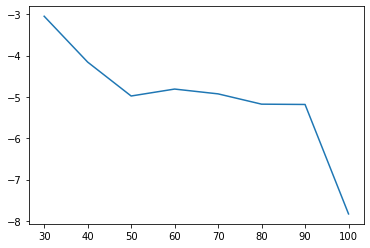

In [106]:
s = pd.Series(pm_results_um.score.values, index=pm_results_um.topic.values)
_ = s.plot()

In [107]:
pm_results_cv = []

for t in range(30, 101, 10):
    lda_model = gensim.models.LdaModel(pm_corpus, id2word=pm_dictionary, num_topics=t)
    corpus_lda = lda_model[pm_corpus]

    cm = CoherenceModel(model=lda_model, texts=lyrics_words_lemmatized, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    pm_results_cv.append(tup)

pm_results_cv = pd.DataFrame(pm_results_cv, columns=['topic', 'score'])

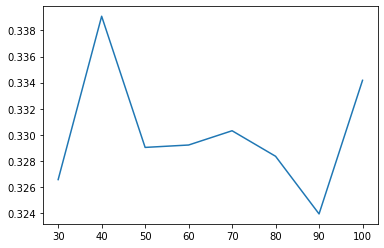

In [108]:
s = pd.Series(pm_results_cv.score.values, index=pm_results_cv.topic.values)
_ = s.plot()

### non-phrase modeling

In [109]:
npm_results_um = []

for t in range(30, 101, 10):
    lda_model = gensim.models.LdaModel(npm_corpus, id2word=npm_dictionary, num_topics=t)
    corpus_lda = lda_model[npm_corpus]

    cm = CoherenceModel(model=lda_model, corpus=corpus_lda, coherence='u_mass')
    score = cm.get_coherence()
    tup = t, score
    npm_results_um.append(tup)

npm_results_um = pd.DataFrame(npm_results_um, columns=['topic', 'score'])

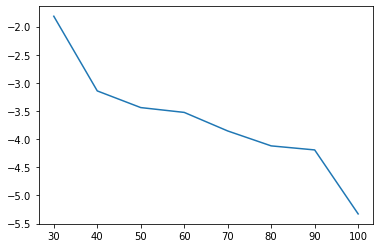

In [110]:
s = pd.Series(npm_results_um.score.values, index=npm_results_um.topic.values)
_ = s.plot()

In [112]:
npm_results_cv = []

for t in range(30, 101, 10):
    lda_model = gensim.models.LdaModel(npm_corpus, id2word=npm_dictionary, num_topics=t)
    corpus_lda = lda_model[npm_corpus]

    cm = CoherenceModel(model=lda_model, texts=words, coherence='c_v')
    score = cm.get_coherence()
    tup = t, score
    npm_results_cv.append(tup)

npm_results_cv = pd.DataFrame(npm_results_cv, columns=['topic', 'score'])

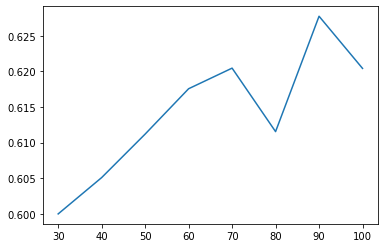

In [113]:
s = pd.Series(npm_results_cv.score.values, index=npm_results_cv.topic.values)
_ = s.plot()

### bigger_comp - towardsds

In [119]:
#helper func
def compute_coherence_values(corpus, dictionary, texts, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
corpus = pm_corpus
dictionary = pm_dictionary

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 40
max_topics = 110
step_size = 10
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, texts =lyrics_words_lemmatized, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_pm.csv', index=False)
    pbar.close()

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 392/540 [5:21:40<5:30:38, 134.04s/it]

In [125]:
corpus = npm_corpus
dictionary = npm_dictionary
texts = words

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 40
max_topics = 110
step_size = 10
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, texts=texts, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_npm.csv', index=False)
    pbar.close()

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 420/540 [3:19:00<56:51, 28.43s/it]


# References

1. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
2. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
3. https://medium.com/@benzgreer/sklearn-lda-vs-gensim-lda-691a9f2e9ab7
4. https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/
5. https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
6. https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html
7. https://datascience.oneoffcoder.com/topic-modeling-gensim.html
8. https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm

